# Quickstart

This notebook shows how to train and validate a model with ScAPE and how to do predictions for cell/drug combinations

In [1]:
# Disable all warnings
import scape
import pandas as pd

scape.__version__

'0.1.1'

In [2]:
df_de = scape.io.load_slogpvals("../../_data/de_train.parquet")
df_lfc = scape.io.load_lfc("../../_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

In [3]:
# We select only a subset of the genes for the model (top most variant genes)
n_genes = 64
top_genes = scape.util.select_top_variable([df_de], k=n_genes)

# Data sources point to the dataframes with the data from which the features are extracted
data_sources = {
    'slogpval': df_de,
    'lfc_pseudo': df_lfc
}

# Define the way in which the features are extracted from the data sources
feature_extraction = {
    'slogpval_drug': {
        'source': 'slogpval',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'lfc_drug': {
        'source': 'lfc_pseudo',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'slogpval_cell': {
        'source': 'slogpval',
        'groupby': 'cell_type',
        'function': 'median'
    },
    'lfc_cell': {
        'source': 'lfc_pseudo',
        'groupby': 'cell_type',
        'function': 'median'
    }
}

# Names of the input layers -> feature extraction method
input_mapping = {
    'in_slogpval_drug': 'slogpval_drug',
    'in_lfc_drug': 'lfc_drug',
    'in_slogpval_cell_encoder': 'slogpval_cell',
    'in_lfc_cell_encoder': 'lfc_cell',
    'in_slogpval_cell_decoder': 'slogpval_cell',
    'in_lfc_cell_decoder': 'lfc_cell',
}

# Configuration for the NN architecture
config = {
    "inputs": {
        "in_slogpval_drug"          : [n_genes, 256, 128],
        "in_lfc_drug"               : [n_genes, 256, 128],
    },
    "conditional_encoder_input_structure": {
        "in_slogpval_cell_encoder"  : [n_genes, 32],
        "in_lfc_cell_encoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_structure": {
        "in_slogpval_cell_decoder"  : [n_genes, 32],
        "in_lfc_cell_decoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_hidden_sizes": [32],
    "encoder_hidden_layer_sizes": [128, 128],
    "decoder_hidden_layer_sizes": [128, 512],
    "outputs": {
        "logpval": (df_de.shape[1], "linear"), 
    },
    # Layer config
    "noise": 0.01,
    "dropout": 0.05,
    "l1": 0,
    "l2": 0
}

model_setup = {
    "data_sources": data_sources,
    "feature_extraction": feature_extraction,
    "input_mapping": input_mapping,
    "output_genes": df_de.columns,
    "config": config
}

# Create model
scm = scape.SCAPE(model_setup)
scape.util.plot(scm.model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [4]:
scm.model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_slogpval_drug    │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_drug         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_slogpval_cell_e… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_cell_encoder │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 128)       │    198,288 │ in_slogpval_drug… │
│ (Functional)        │                   │            │ in_lfc_drug[0][0… │
│                     │                   │            │ in_slogpval_cell… │
│                     │                   │            │ in_lfc_cell_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_slogpval_cell_d… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_cell_decoder │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 18211)     │  9,439,187 │ encoder[0][0],    │
│ (Functional)        │                   │            │ in_slogpval_cell… │
│                     │                   │            │ in_lfc_cell_deco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,637,475 (36.76 MB)

 Trainable params: 9,632,483 (36.75 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [5]:
result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=300,
    baselines=["zero", "slogpval_drug"]
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Epoch    1: val_loss None -> 1.4147, train loss: 1.3065 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0089, 0.88%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7972, -25.45%
Epoch    2: val_loss 1.4147 -> 1.3626, train loss: 1.2764 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0475, 4.53%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8277, -20.82%
Epoch    3: val_loss 1.3626 -> 1.3504, train loss: 1.2543 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0569, 5.38%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8351, -19.74%
Epoch    7: val_loss 1.3504 -> 1.3281, trai

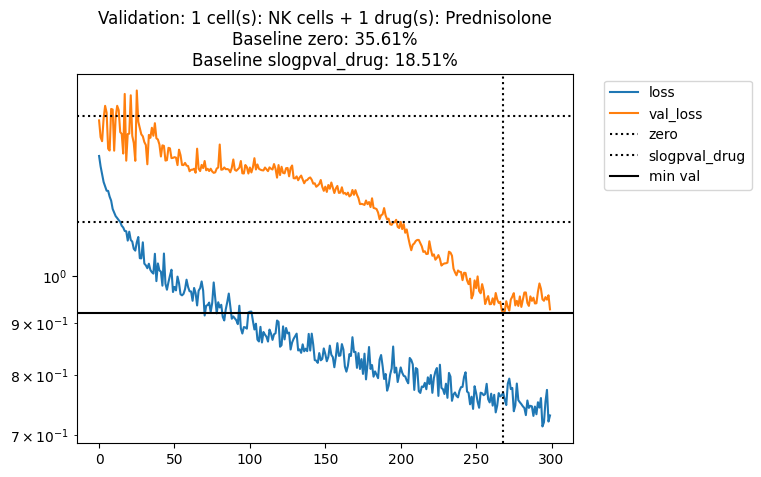

In [6]:
scape.util.plot_result(result, legend=True)

## Inference

In [7]:
# Predict using a given dataframe index
scm.predict(df_de)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.203828,0.150523,0.020758,0.099469,0.247057,0.450147,0.051619,0.226590,-0.164057,0.121938,...,0.005613,-0.073183,-0.040510,0.117368,0.148821,0.111490,0.151680,0.097412,0.075550,0.070037
T cells CD4+,Clotrimazole,0.078294,0.009850,0.100158,-0.008600,0.180912,0.288470,-0.097463,0.148364,-0.076366,0.197138,...,-0.202345,0.076084,0.064597,0.072072,0.351836,0.072448,0.199415,0.111804,0.173586,-0.050875
T cells CD8+,Clotrimazole,-0.109506,-0.339565,-0.150545,0.074193,0.016025,-0.229050,-0.108762,-0.137485,-0.378547,0.187158,...,0.031773,-0.332012,-0.332357,-0.325576,0.023069,-0.209736,0.049552,-0.070895,-0.034473,-0.144361
T regulatory cells,Clotrimazole,0.340189,0.277995,0.448396,0.686293,0.673915,0.581366,-0.075343,0.359791,-0.162233,0.132574,...,-0.072457,0.343853,0.057203,0.285858,0.516205,0.498713,0.402403,0.255057,-0.049675,-0.041624
NK cells,Mometasone Furoate,1.414286,-0.064287,-0.459859,-0.431617,0.280233,1.776894,0.195304,1.183871,-0.432086,2.535164,...,-0.410355,-0.360329,0.604417,-0.363562,-0.014817,0.777200,0.087769,0.749953,-1.691646,0.676934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T regulatory cells,Atorvastatin,-0.046699,-0.279498,-0.332703,-0.349053,-0.258824,-0.237498,-0.089770,-0.460262,-0.168422,0.016466,...,-0.220815,-0.385130,-0.272267,-0.419541,-0.287092,-0.047059,-0.184361,-0.041354,-0.011884,-0.396104
NK cells,Riociguat,0.079433,0.210215,0.069947,0.058385,0.145944,0.279878,0.032356,0.241953,-0.272361,0.043571,...,0.030069,-0.050761,-0.140042,0.049951,0.011019,0.070881,0.131151,0.006017,0.115188,-0.049629
T cells CD4+,Riociguat,0.176004,0.064307,0.082908,-0.052718,0.060703,0.086562,-0.071568,0.045546,-0.058872,0.072279,...,-0.087925,0.011940,-0.037161,0.138478,0.240762,0.133038,0.213113,-0.017281,0.204640,-0.115178


In [8]:
# Predict from a given multi-index
scm.predict(
    pd.MultiIndex.from_tuples([
        ("NK cells", "Bosutinib"),
        ("NK cells", "Belinostat"),
        ("Myeloid cells", "Bosutinib"),
        ("Myeloid cells", "Belinostat"),
    ], names=["cell_type", "sm_name"])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1      A2MP1  \
cell_type     sm_name                                                           
NK cells      Bosutinib   0.369067  0.186561  -0.076107   0.019033   0.384568   
              Belinostat  1.336801  3.678491 -10.552170 -21.420418  -5.821821   
Myeloid cells Bosutinib   0.382470  0.046028  -0.507916  -0.236897   2.744847   
              Belinostat  3.397980  2.290117 -11.332633  -1.493437  14.167448   

                            A4GALT      AAAS      AACS     AAGAB      AAK1  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.850436  0.174786  0.321700 -0.145179  0.146801   
              Belinostat  8.143426  0.955024  0.889133  6.850868  7.760525   
Myeloid cells Bosutinib   1.061190  0.348175  0.066542  0.309599  0.358204   
              Belinostat  5.132761  0.455020 -1.312620  2.557202  5.532474   

                          ...      ZUP1      ZW10    ZWILCH     ZWINT  \
cell_type     sm_name     ...                                           
NK cells      Bosutinib   ...  0.005999 -0.130837  0.045746  0.143082   
              Belinostat  ...  7.317244  1.792165 -3.927366 -0.034536   
Myeloid cells Bosutinib   ... -0.748373 -0.408017 -0.320326 -0.516336   
              Belinostat  ...  2.556652 -0.388645 -7.664632 -2.831765   

                              ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.153639  0.167966  0.214357  0.120676  0.038759   
              Belinostat -3.424027 -0.150006 -2.028555  5.755276 -0.811614   
Myeloid cells Bosutinib   0.483470 -0.110649 -0.295003 -0.103413 -0.321483   
              Belinostat -0.530172 -1.067147 -3.161911  0.839952  1.891696   

                             ZZEF1  
cell_type     sm_name               
NK cells      Bosutinib   0.109750  
              Belinostat -2.836930  
Myeloid cells Bosutinib   0.031168  
              Belinostat  0.226440  

[4 rows x 18211 columns]

In [9]:
# Predict from tuples
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                          
NK cells  Bosutinib   0.369067  0.186561  -0.076107   0.019033  0.384568   
          Belinostat  1.336800  3.678491 -10.552170 -21.420416 -5.821821   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.850436  0.174786  0.321700 -0.145179  0.146801  ...   
          Belinostat  8.143426  0.955024  0.889133  6.850868  7.760525  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib   0.005999 -0.130837  0.045746  0.143082  0.153639   
          Belinostat  7.317244  1.792165 -3.927367 -0.034537 -3.424026   

                          ZXDB      ZXDC    ZYG11B       ZYX    ZZEF1  
cell_type sm_name                                                      
NK cells  Bosutinib   0.167966  0.214357  0.120676  0.038759  0.10975  
          Belinostat -0.150007 -2.028555  5.755278 -0.811615 -2.83693  

[2 rows x 18211 columns]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


<Axes: xlabel='y', ylabel='y_pred'>

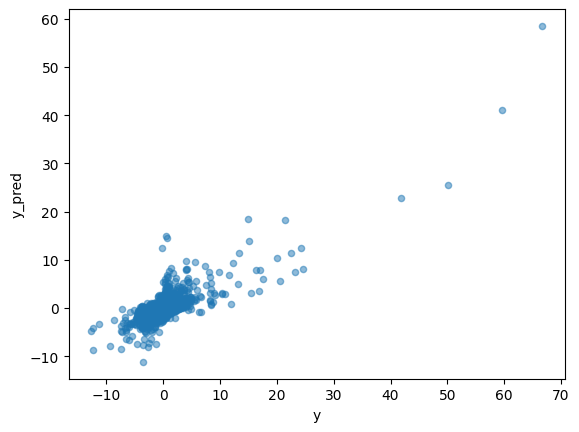

In [10]:
# Plot correlation between predicted and observed values
df_cmp = pd.DataFrame({
    'y': df_de.loc[("NK cells", "Prednisolone")].values.ravel(), 
    'y_pred': scm.predict([("NK cells", "Prednisolone")]).values.ravel()
})

# Make the plot square with same X and Y limits
df_cmp.plot.scatter(x='y', y='y_pred', alpha=0.5)

In [11]:
# Save model
scm.save("../../_models/config.pkl", "../../_models/model.weights.h5", "../../_models/result.pkl")

In [12]:
scm = scape.SCAPE.load("../../_models/config.pkl", "../../_models/model.weights.h5", "../../_models/result.pkl")
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                          
NK cells  Bosutinib   0.369067  0.186561  -0.076107   0.019033  0.384568   
          Belinostat  1.336800  3.678491 -10.552170 -21.420416 -5.821821   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.850436  0.174786  0.321700 -0.145179  0.146801  ...   
          Belinostat  8.143426  0.955024  0.889133  6.850868  7.760525  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib   0.005999 -0.130837  0.045746  0.143082  0.153639   
          Belinostat  7.317244  1.792165 -3.927367 -0.034537 -3.424026   

                          ZXDB      ZXDC    ZYG11B       ZYX    ZZEF1  
cell_type sm_name                                                      
NK cells  Bosutinib   0.167966  0.214357  0.120676  0.038759  0.10975  
          Belinostat -0.150007 -2.028555  5.755278 -0.811615 -2.83693  

[2 rows x 18211 columns]

## Save during training

In [13]:
scm = scape.SCAPE(model_setup)

result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=30,
    baselines=["zero", "slogpval_drug"],
    output_folder="../../_models",
    config_file_name="example_config.pkl",
    model_file_name=f"example_model.keras",
    result_file_name="example_result.pkl"
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Model will be saved to ../../_models/example_model.keras
Epoch    1: val_loss None -> 1.4237, train loss: 1.3068 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0025, 0.25%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7921, -26.24%
Epoch    2: val_loss 1.4237 -> 1.4015, train loss: 1.2814 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0184, 1.81%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8047, -24.27%
Epoch    3: val_loss 1.4015 -> 1.3506, train loss: 1.2519 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0568, 5.37%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.

In [14]:
# Check that the error is the same
scm = scape.model.SCAPE.load( "../../_models/example_config.pkl", "../../_models/example_model.weights.h5", "../../_models/example_result.pkl")

y_true = df_de.loc[(df_de.index.get_level_values("cell_type") == "NK cells") & (df_de.index.get_level_values("sm_name") == "Prednisolone")]
y_pred = scm.predict([("NK cells", "Prednisolone")])

scape.losses.np_mrrmse(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


np.float64(1.3016312057532147)